In [2]:
#!pip install efficientnet

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
metadata = pd.read_csv("data/HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
diagnosis_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

metadata['diagnosis_full'] = metadata['dx'].map(diagnosis_map)
metadata['image_path'] = metadata['image_id'] + ".jpg"

In [8]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis_full,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,ISIC_0031633.jpg


In [10]:
resized_dir = "data/resized_images/"
os.makedirs(resized_dir, exist_ok=True)

for image_id in metadata['image_id']:
    img_path = os.path.join("data/all_images", f"{image_id}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(os.path.join(resized_dir, f"{image_id}.jpg"), img)

In [11]:
train_df, test_df = train_test_split(metadata, test_size=0.15, stratify=metadata['dx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['dx'], random_state=42)

# Save splits
train_df.to_csv("data/train_split.csv", index=False)
val_df.to_csv("data/val_split.csv", index=False)
test_df.to_csv("data/test_split.csv", index=False)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 7235 | Val: 1277 | Test: 1503


In [12]:
train_df = pd.read_csv("data/train_split.csv")
val_df = pd.read_csv("data/val_split.csv")
test_df = pd.read_csv("data/test_split.csv")

# Combine for full view if needed
full_df = pd.concat([train_df, val_df, test_df], axis=0)

In [13]:
#print(test_df)

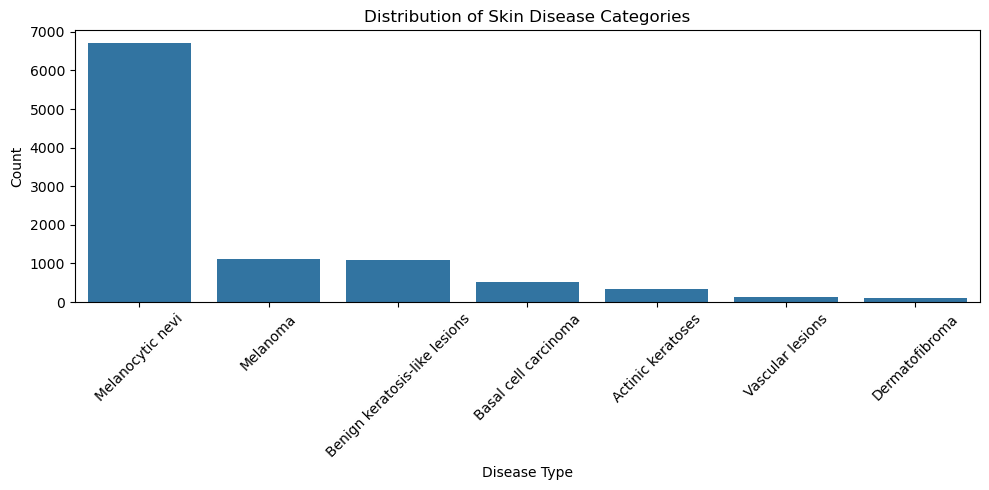

In [14]:
#View Class Distribution
plt.figure(figsize=(10,5))
sns.countplot(data=full_df, x='diagnosis_full', order=full_df['diagnosis_full'].value_counts().index)
plt.title('Distribution of Skin Disease Categories')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

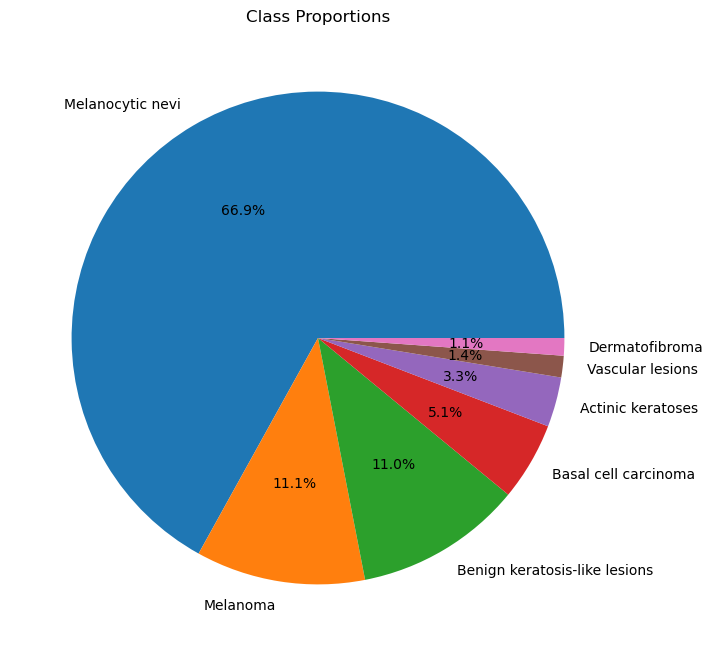

In [15]:
#Visualize Class Proportion (%)
class_percent = full_df['diagnosis_full'].value_counts(normalize=True) * 100
class_percent.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8), title="Class Proportions")
plt.ylabel("")
plt.show()

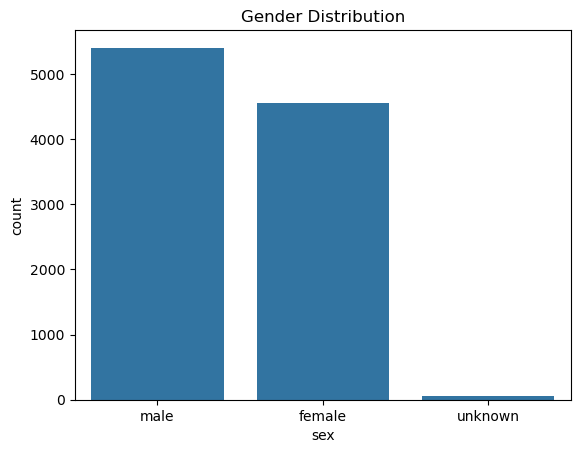

In [16]:
#Gender Distribution
sns.countplot(data=full_df, x='sex')
plt.title('Gender Distribution')
plt.show()

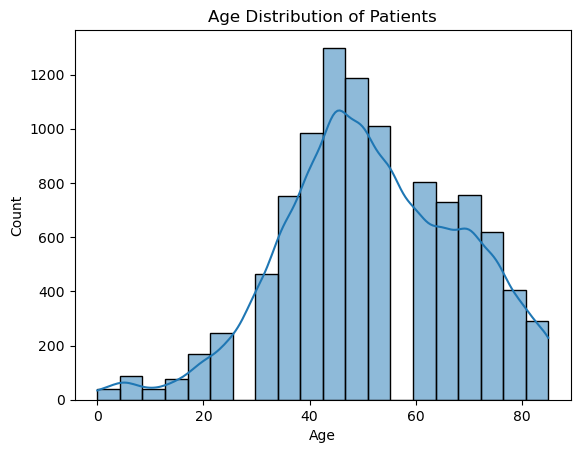

In [30]:
#age Distribution
sns.histplot(full_df['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.show()

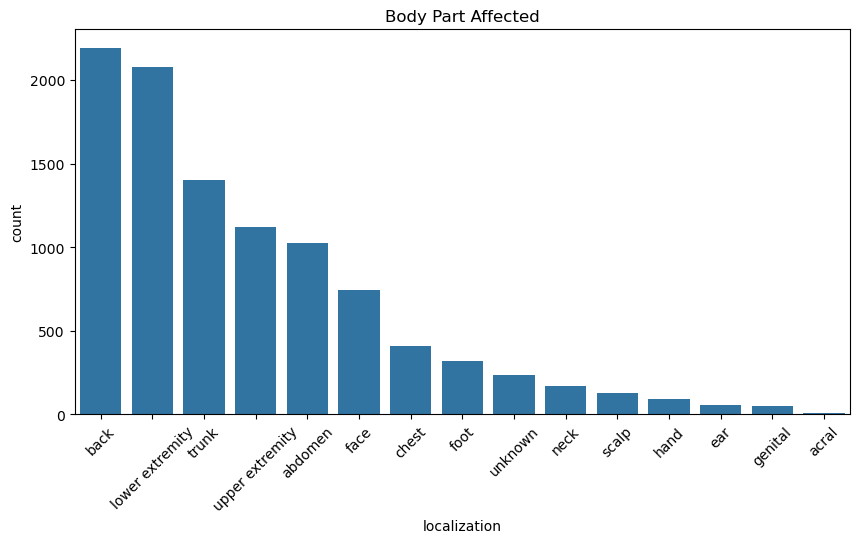

In [32]:
#Lesion Location Distribution
plt.figure(figsize=(10,5))
sns.countplot(data=full_df, x='localization', order=full_df['localization'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Body Part Affected')
plt.show()

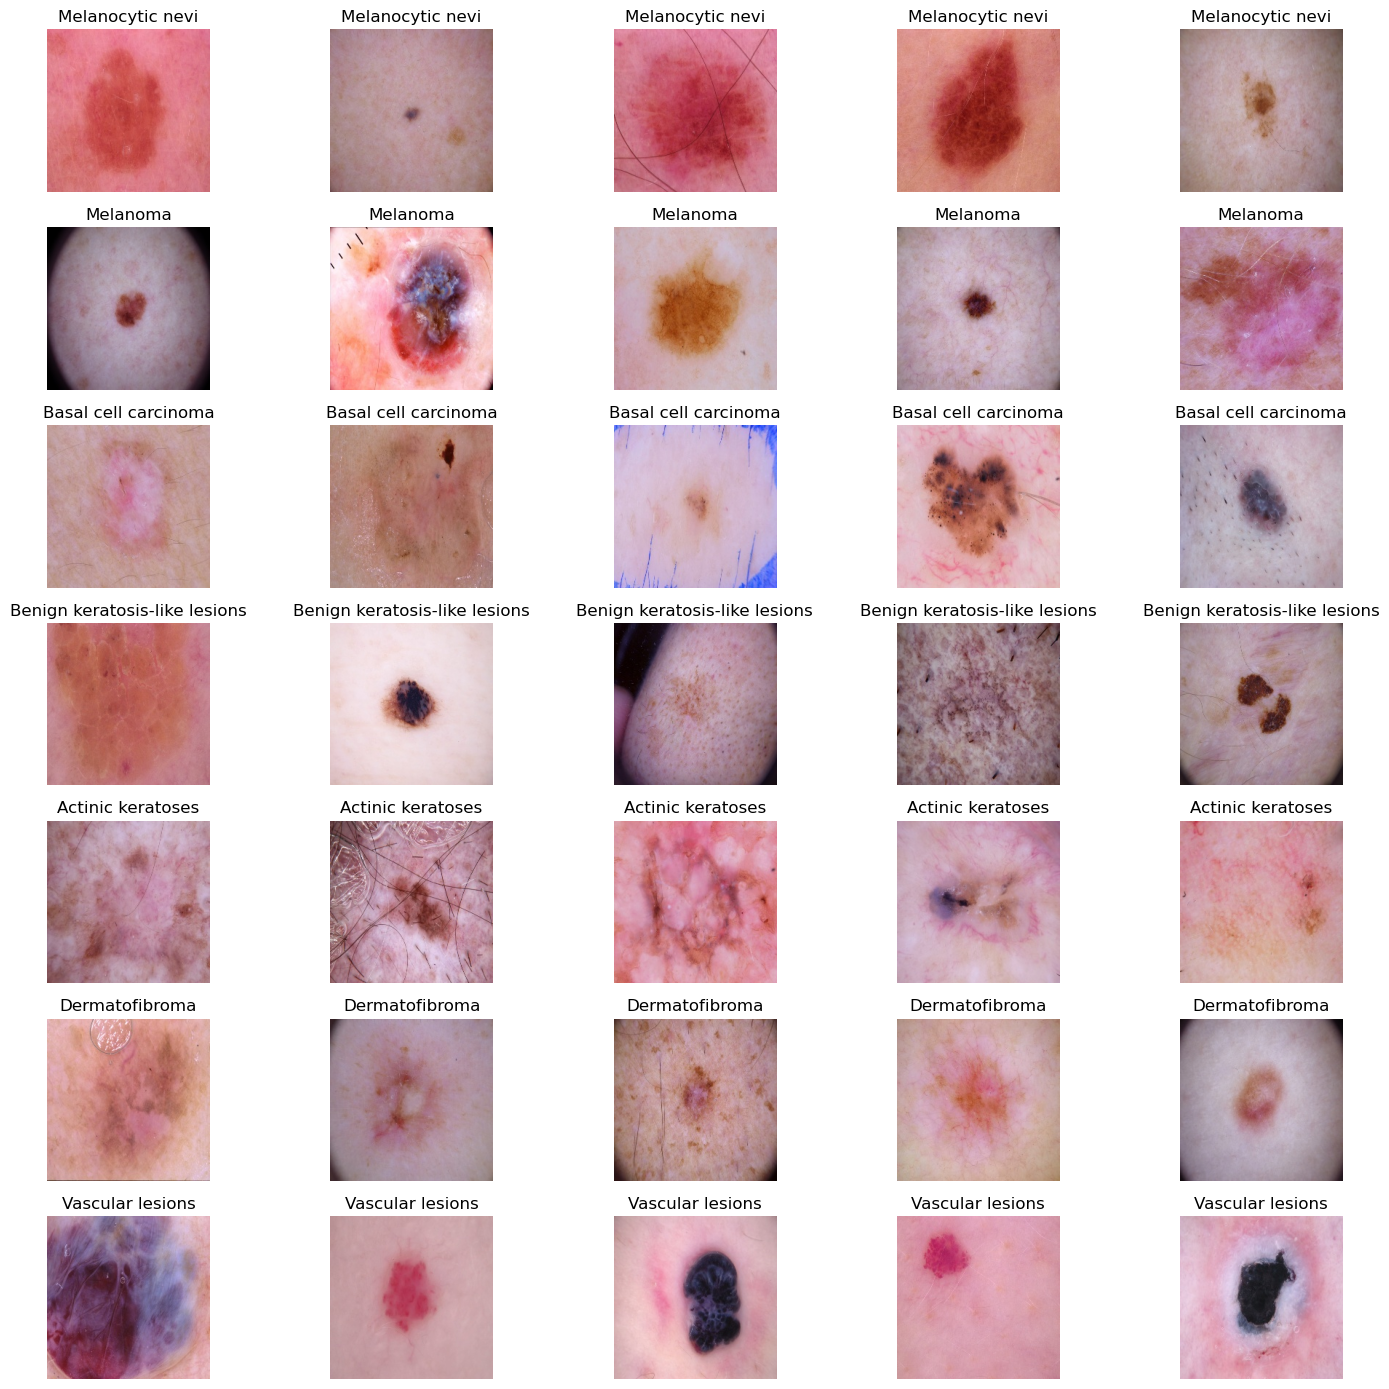

In [18]:
#Display Sample Images Per Class
import cv2
import matplotlib.pyplot as plt

def show_images_per_class(df, class_col, image_col, num=5):
    classes = df[class_col].unique()
    plt.figure(figsize=(15, len(classes)*2))
    
    for i, c in enumerate(classes):
        sample = df[df[class_col] == c].sample(num)
        for j, img_id in enumerate(sample[image_col]):
            img = cv2.imread(f"data/resized_images/{img_id}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(classes), num, i*num + j + 1)
            plt.imshow(img)
            plt.title(c)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_per_class(full_df, 'diagnosis_full', 'image_path', num=5)

In [27]:
#Class Imbalance Ratio
class_counts = full_df['diagnosis_full'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Most common class count: {class_counts.max()}")
print(f"Least common class count: {class_counts.min()}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

Most common class count: 6705
Least common class count: 115
Imbalance ratio: 58.30


In [29]:
#Save Updated DataFrame (optional)
# Save with full paths and full labels
full_df.to_csv("data/metadata_with_labels.csv", index=False)

In [31]:
train_df = pd.read_csv("data/train_split.csv")
val_df = pd.read_csv("data/val_split.csv")
test_df = pd.read_csv("data/test_split.csv")

In [33]:
# Add full image path for generators
train_df['image_path'] = "data/resized_images/" + train_df['image_id'] + ".jpg"
val_df['image_path'] = "data/resized_images/" + val_df['image_id'] + ".jpg"
test_df['image_path'] = "data/resized_images/" + test_df['image_id'] + ".jpg"

# Set target column for generators
target_col = 'dx'

In [35]:
#print(test_df)

In [53]:
#Create ImageDataGenerators
IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [55]:
#Flow From DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col=target_col,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col=target_col,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col=target_col,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7235 validated image filenames belonging to 7 classes.
Found 1277 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


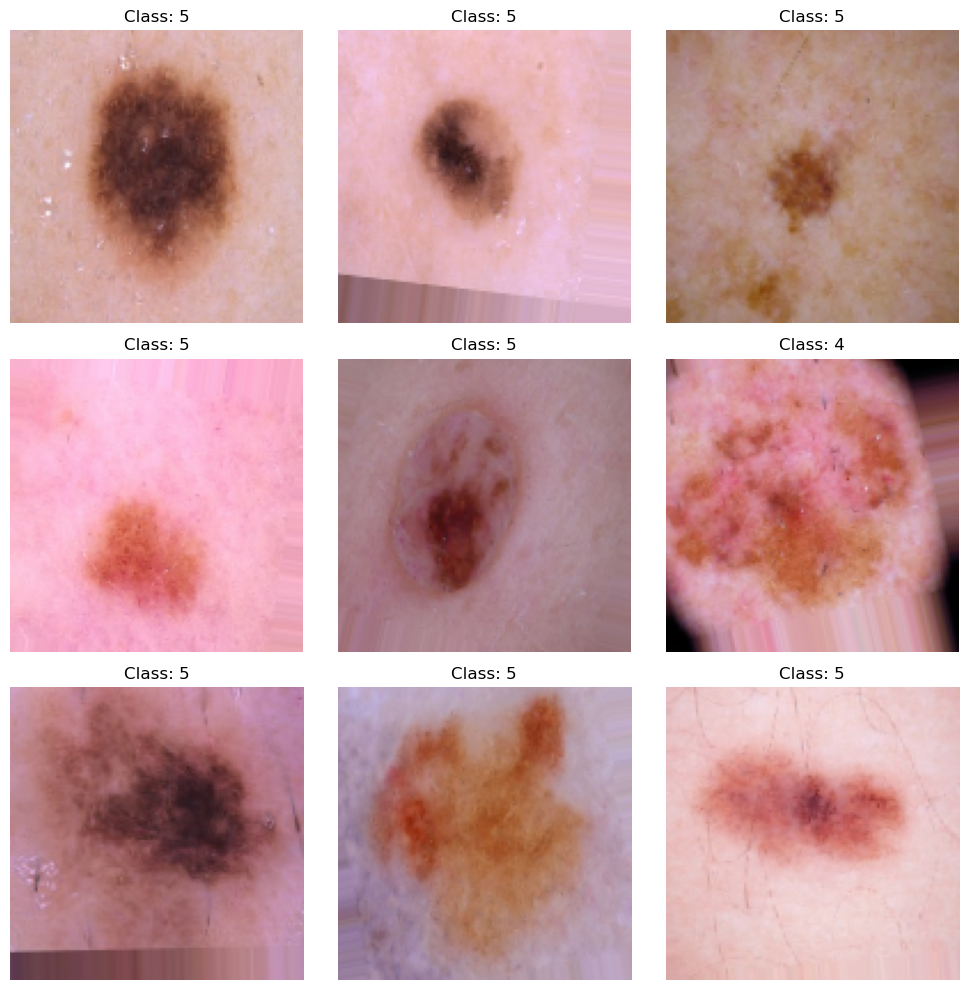

In [57]:
#Visualize Augmented Samples
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [59]:
#Save Class Indices Mapping (for predictions later)
label_map = train_generator.class_indices
reverse_map = dict((v, k) for k, v in label_map.items())

# Optional: save to JSON
import json
with open("data/label_map.json", "w") as f:
    json.dump(reverse_map, f)

In [71]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze feature extractor

# Get number of classes from the generator
num_classes = len(train_generator.class_indices)

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

In [73]:
#Compile the Model

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
#Set Up Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

In [79]:
#Train the Model
#Use class_weight=class_weight_dict only if imbalance is an issue (from Week 3).

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=None  # or use class_weight_dict if needed
)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.7307 - loss: 0.7521 - val_accuracy: 0.7165 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7346 - loss: 0.7642

227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.7346 - loss: 0.7642 - val_accuracy: 0.7251 - val_loss: 0.7381 - learning_rate: 0.0010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7337 - loss: 0.7400 - val_accuracy: 0.7361 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7460 - loss: 0.7005

227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.7460 - loss: 0.7006 - val_accuracy: 0.7330 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7487 - loss: 0.6993 - val_accuracy: 0.7306 - val_loss: 0.7595 - learning_rate: 0.0010
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7511 - loss: 0.6893 - val_accuracy: 0.7314 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7473 - loss: 0.6877

227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.7473 - loss: 0.6878 - val_accuracy: 0.7369 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7424 - loss: 0.7257 - val_accuracy: 0.7384 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7493 - loss: 0.6985 - val_accuracy: 0.6985 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7534 - loss: 0.6860

227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7534 - loss: 0.6860 - val_accuracy: 0.7486 - val_loss: 0.6977 - learning_rate: 0.0010


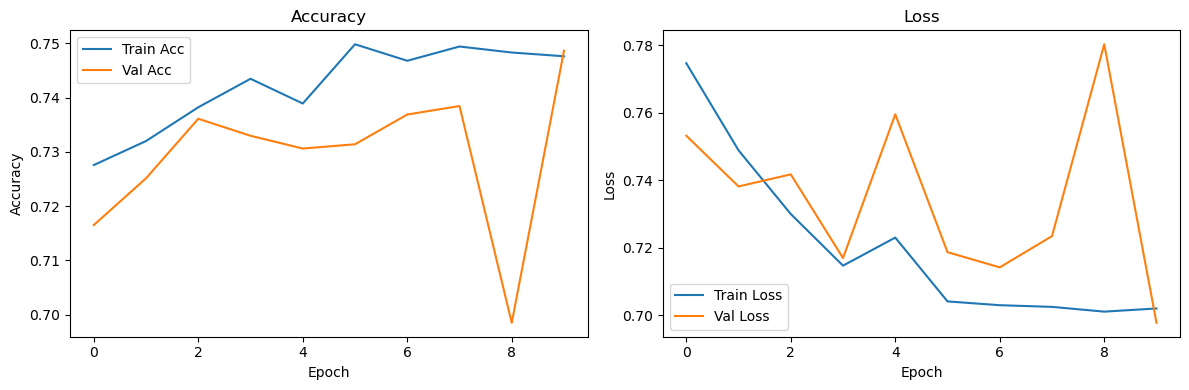

In [81]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [83]:
model.save("final_skin_model.h5")

In [85]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load model
model = load_model("final_skin_model.h5")

# Predict
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Class labels
labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
              precision    recall  f1-score   support

       akiec       0.91      0.20      0.33        49
         bcc       0.54      0.32      0.41        77
         bkl       0.45      0.42      0.43       165
          df       0.50      0.12      0.19        17
         mel       0.41      0.18      0.25       167
          nv       0.80      0.95      0.87      1006
        vasc       0.58      0.64      0.61        22

    accuracy                           0.73      1503
   macro avg       0.60      0.40      0.44      1503
weighted avg       0.70      0.73      0.70      1503



In [87]:
#valuate Model on Test Set
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load model
model = load_model("final_skin_model.h5")

# Predict
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Class labels
labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
              precision    recall  f1-score   support

       akiec       0.91      0.20      0.33        49
         bcc       0.54      0.32      0.41        77
         bkl       0.45      0.42      0.43       165
          df       0.50      0.12      0.19        17
         mel       0.41      0.18      0.25       167
          nv       0.80      0.95      0.87      1006
        vasc       0.58      0.64      0.61        22

    accuracy                           0.73      1503
   macro avg       0.60      0.40      0.44      1503
weighted avg       0.70      0.73      0.70      1503



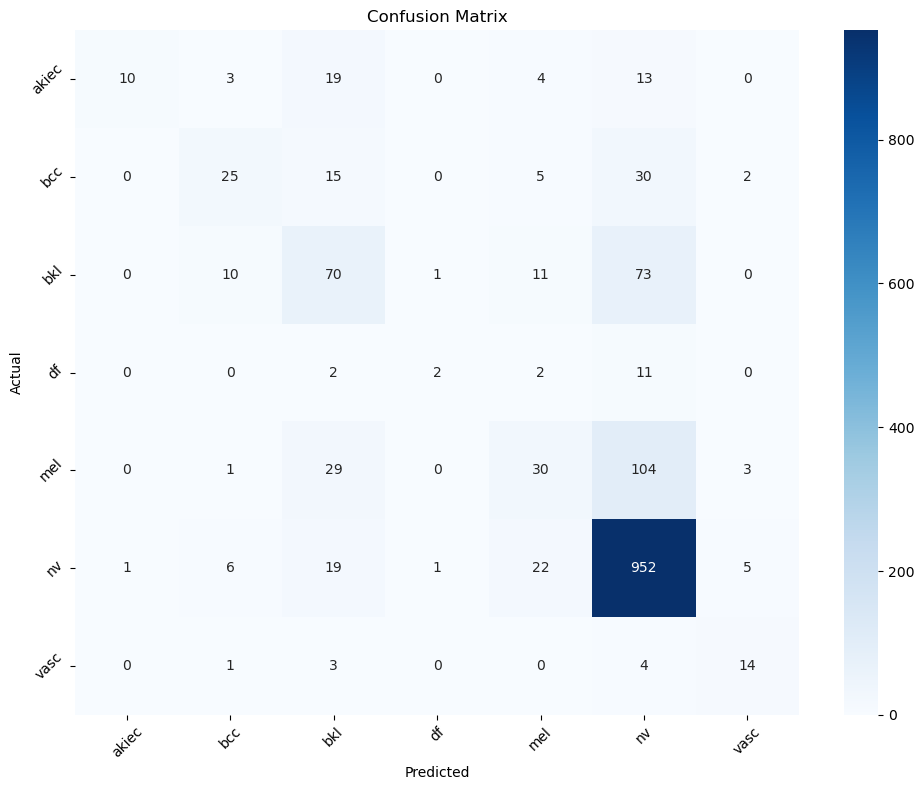

In [89]:
#Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()